In [2]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.regularizers import L1L2

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

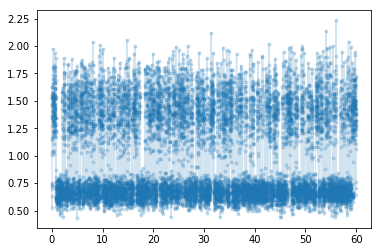

<Figure size 432x288 with 0 Axes>

In [6]:
i = randint(0,4000)
Ft = load("syndat/d"+str(i).zfill(4)+".npy")
t = arange(len(Ft))*5e-3
figure()
plot(t,Ft,'.-',alpha=0.2)
figure()
#x = graph_spectrogram("syndat/d0000.npy")

In [7]:
i

2356

In [8]:
Tx = len(Ft)
nfreq = 101

In [9]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [10]:
pars = load("syndat/pars.npy")
print(len(pars),pars[0])

4200 [1.52550541 2.48263258 4.59159414 1.        ]


In [11]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 2000 


X = []
Y = []
for i in range(4000):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        start,end = get_random_time_segment(nframes)
        X.append(xt[start:end])
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(clip(yt[start:end].flatten()+(par[-1]>1),0,1))
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(clip(yt[start:end].flatten()+(par[-1]>1),0,1))
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(20000, 2000) (20000, 2000)
(500, 2000) (500, 2000)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

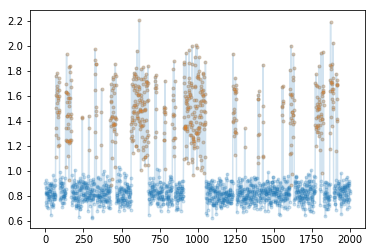

In [12]:
colors = array(['C0','C1'])
t = arange(2000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[1])
plot(t,X[i,:],'.-',alpha=0.2)
plot(t[Y[i,:]==0],X[i,Y[i,:]==0],'.',alpha=0.2)

In [13]:
max(Y[i,:])

1

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [14]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],1))

In [15]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    X_input = Input(shape = input_shape)
    
    # Layers

    X = X_input

    Xa = Conv1D(20,10,strides = 4,padding="same")(X)
    Xa = BatchNormalization()(Xa)
    Xa = Activation("relu")(Xa)

    Xa = Conv1D(40,5,strides = 2,padding="same")(Xa)
    Xa = BatchNormalization()(Xa)
    Xa = Activation("relu")(Xa)

    X = Dense(10,activation="relu")(Xa)
    X = Dense(16,activation="relu")(X)
    #Xb = Dense(10,activation="softmax")(X)
    #X = Concatenate()([Xa,Xb])
    X = Reshape((2000,2))(X)

    X = Dense(1,activation="sigmoid")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [16]:
model = model(input_shape = (nframes,1))

In [17]:
opt = Adam(lr=0.005, beta_1=0.90, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [18]:
model.load_weights("./network20180417c.h5")
#model.set_weights(Wsave)

5.48 5.46 0.02 0.095


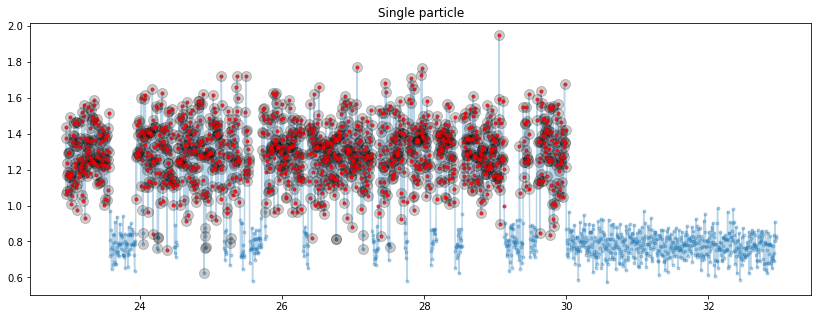

In [22]:
figure(figsize=(14,5))
i = 4031
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("Single particle")

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)

1.375 1.315 0.06 0.03


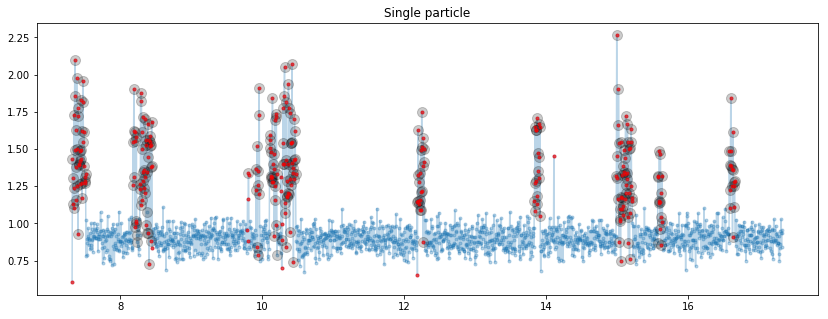

In [26]:
figure(figsize=(14,5))
i = 4003
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("Single particle")

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)

10.0 0.06 9.94 0.0


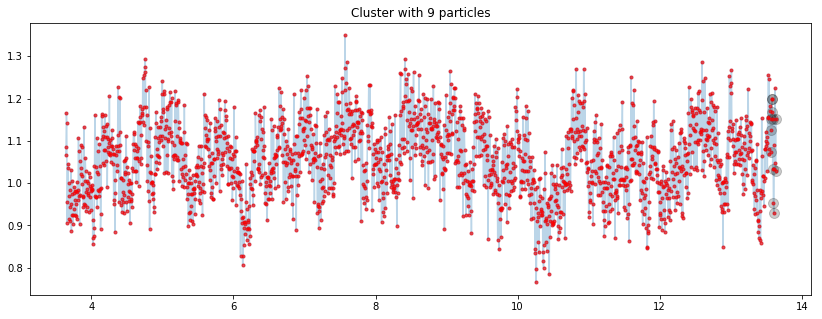

In [48]:
figure(figsize=(14,5))
i = 4020
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("Single particle")

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)

7.01 1.485 5.525 0.02


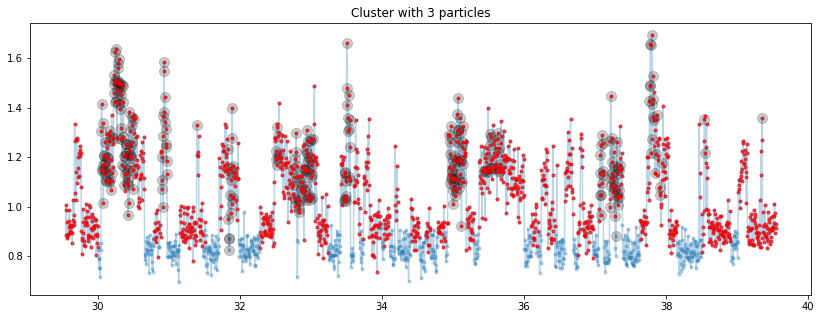

In [74]:
figure(figsize=(14,5))
i = 4144
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("Single particle")

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)